# Lunar Lander Deep-single-q and double-q networks

In [1]:
import gym
import numpy as np
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical

import matplotlib.pyplot as plt

max_epochs = 20
mem_size = 40000
batch_size = 100
blank = 20

env = gym.make("LunarLander-v2")

Using TensorFlow backend.


Memory buffer to store experiences

In [2]:
from collections import deque

class Memory:
    def __init__(self, size, samplesize):
        self.samplesize = samplesize
        self.memory = deque(maxlen=size)
        self.size = size
    
    def remember(self, experience):
        self.memory.append(experience)
    
    def sample(self):
        indecies = np.random.choice(np.arange(self.size), size=self.samplesize, replace = False)
        return [self.memory[index] for index in indecies]       
        

# Double q learning agent

In [3]:
class Agent_q_double():
    def __init__(self, state_dim, action_dim):
        self.action_dim = action_dim
        
        self.model_a = Sequential()
        self.model_a.add(Dense(128, activation='relu', input_shape=(state_dim,)))
        self.model_a.add(Dense(64, activation = 'relu'))
        self.model_a.add(Dense(action_dim, activation = 'linear'))
        adam_a = keras.optimizers.Adam(lr=0.001)
        self.model_a.compile(optimizer= adam_a, loss='mse', metrics=['accuracy'])

        self.model_b = Sequential()
        self.model_b.add(Dense(128, activation='relu', input_shape=(state_dim,)))
        self.model_b.add(Dense(64, activation = 'relu'))
        self.model_b.add(Dense(action_dim, activation = 'linear'))
        adam_b = keras.optimizers.Adam(lr=0.001)
        self.model_b.compile(optimizer= adam_b, loss='mse', metrics=['accuracy'])
        
    def predict(self, state):
        return np.argmax((self.model_a.predict(np.array([state]))+self.model_b.predict(np.array([state]))))
    
    def train(self, experiences):
        state, action, reward, next_state, done = zip(*experiences)
        state = np.array(state)
        action = np.array(action)
        reward = np.array(reward)
        next_state = np.array(next_state)
        done = np.array(done)
        
        if np.random.uniform() < 0.5:
            estimator = self.model_a
            estimee = self.model_b
        else:
            estimator = self.model_b
            estimee = self.model_a
            
        next_q_predicts = estimee.predict(next_state)
        next_q_actual = estimator.predict(next_state)
        
        indecies = to_categorical(np.argmax(next_q_predicts, axis = 1),num_classes=self.action_dim)

        next_q_actual = next_q_actual*indecies
        target_q_vals = reward + 0.99 * np.max(next_q_actual, axis = 1) * done
        
        bad_target = estimee.predict(state)
        
        mask = to_categorical(action, num_classes=self.action_dim)
        
        good_target = mask*target_q_vals[:, np.newaxis] + (1-mask)*bad_target
            
        estimee.fit(state, good_target, batch_size=batch_size, verbose = 0)
        
    def save_model(self, epoch):
        self.model_a.save_weights('models/double_weights_a' + str(epoch) + '.h5')
        self.model_b.save_weights('models/double_weights_b' + str(epoch) + '.h5')
        
    def load_model(self, epoch):
        self.model_a.load_weights('models/double_weights_a' + str(epoch) + '.h5')
        self.model_b.load_weights('models/double_weights_b' + str(epoch)+ '.h5')

# Simple q learning agent

In [4]:
class Agent_q():
    def __init__(self, state_dim, action_dim):
       
        self.action_dim = action_dim
        self.model = Sequential()
        self.model.add(Dense(128, activation='relu', input_shape=(state_dim,)))
        self.model.add(Dense(64, activation = 'relu'))
        self.model.add(Dense(action_dim, activation = 'linear'))
        adam = keras.optimizers.Adam(lr=0.001)
        self.model.compile(optimizer= adam, loss='mse', metrics=['accuracy'])
        
    def predict(self, state):
        return np.argmax(self.model.predict(np.array([state])))
    
    def train(self, experiences):
        state, action, reward, next_state, done = zip(*experiences)
        state = np.array(state)
        action = np.array(action)
        reward = np.array(reward)
        next_state = np.array(next_state)
        done = np.array(done)
        
        next_q_vals = self.model.predict(next_state)
        target_q_vals = reward + 0.99 * np.max(next_q_vals, axis=1) * done
        
        bad_target = self.model.predict(state)
        mask = to_categorical(action, num_classes=self.action_dim)
        good_target = mask*target_q_vals[:, np.newaxis] + (1-mask)*bad_target
            
        self.model.fit(state, good_target, batch_size=batch_size, verbose = 0)
        
    def save_model(self, epoch):
        self.model.save_weights('models/simple_weights_m' + str(epoch) + '.h5')
    
    def load_model(self, epoch):
        self.model.load_weights('models/simple_weights_m' + str(epoch) + '.h5')

# A q learning agent with a fixed target

In [5]:
class Agent_q_soft_target():
    def __init__(self, state_dim, action_dim):
       
        self.action_dim = action_dim
        self.model = Sequential()
        self.model.add(Dense(128, activation='relu', input_shape=(state_dim,)))
        self.model.add(Dense(64, activation = 'relu'))
        self.model.add(Dense(action_dim, activation = 'linear'))
        adam = keras.optimizers.Adam(lr=0.001)
        self.model.compile(optimizer= adam, loss='mse', metrics=['accuracy'])
        
        self.target = Sequential()
        self.target.add(Dense(128, activation='relu', input_shape=(state_dim,)))
        self.target.add(Dense(64, activation = 'relu'))
        self.target.add(Dense(action_dim, activation = 'linear'))
        adam_t = keras.optimizers.Adam(lr=0.001)
        self.target.compile(optimizer= adam_t, loss='mse', metrics=['accuracy'])
        
        self.target.set_weights(self.model.get_weights()) 
        
    def soft_update(self):
        self.target.set_weights((np.array(self.model.get_weights())*0.2)+(np.array(self.target.get_weights())*0.8))
        
    def predict(self, state):
        return np.argmax(self.model.predict(np.array([state])))
    
    def train(self, experiences):
        state, action, reward, next_state, done = zip(*experiences)
        state = np.array(state)
        action = np.array(action)
        reward = np.array(reward)
        next_state = np.array(next_state)
        done = np.array(done)
        
        next_q_vals = self.target.predict(next_state)
        target_q_vals = reward + 0.99 * np.max(next_q_vals, axis=1) * done
        
        bad_target = self.model.predict(state)
        mask = to_categorical(action, num_classes=self.action_dim)
        good_target = mask*target_q_vals[:, np.newaxis] + (1-mask)*bad_target
            
        self.model.fit(state, good_target, batch_size=batch_size, verbose = 0)
        self.soft_update()
    
    def save_model(self, epoch):
        self.model.save_weights('models/target_weights_m' + str(epoch) + '.h5')
        self.target.save_weights('models/target_weights_t' + str(epoch)+ '.h5')
    
    def load_model(self, epoch):
        self.model.load_weights('models/target_weights_m' + str(epoch) + '.h5')
        self.target.load_weights('models/target_weights_t' + str(epoch)+ '.h5')

A function to test an agent on the environment

In [6]:
def playtest(env, agent):
    state = env.reset()
    done = False
    rewards = 0
    while not done:
        action = agent.predict(state)
        env.render()
        next_state, reward, done, _ = env.step(action)
        rewards+=reward
        if done:
            env.close()
        else:
            state = next_state

In [7]:
def test_run(env, agent, update=False):
    memory = Memory(mem_size,batch_size)
    epsilon = 1
    epsilon_decay = 0.9

    print("Prepopulating memory:")
    print("____________________")
    state = env.reset()
    for step in range(mem_size):
        if step%(mem_size/blank)==0:
            print("|", end='')
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        memory.remember((state, action, reward, next_state, 1-done))
        if done:
            state = env.reset()
        else:
            state = next_state
     
    av_reward = []     
    epoch_reward = 0
    env.reset()
    print("\nTraining:")
    print("____________________")
    for epoch in range(1,max_epochs+1):
        done = False
        state = env.reset()
        while not done:
            if np.random.uniform() < epsilon:
                action = env.action_space.sample()
            else:
                action = agent.predict(state)
        
            next_state, reward, done, _ = env.step(action)
            memory.remember((state, action, reward, next_state, 1-done))
            epoch_reward += reward
            agent.train(memory.sample())
        
            if done:
                if update:
                    agent.soft_update()
                if epsilon > 0.1:
                    epsilon*=epsilon_decay
                av_reward.append(epoch_reward/epoch)
                if epoch%(max_epochs/blank)==0:
                    print("|", end='')
                    playtest(env, agent)
                break
            else:
                state = next_state
    return av_reward

Prepopulating memory:
____________________
||||||||||||||||||||
Training:
____________________
||||||||||
____________________
Prepopulating memory:
____________________
||||||||||||||||||||
Training:
____________________
||||||||||
____________________
Prepopulating memory:
____________________
||||||||||||||||||||
Training:
____________________
||||||||||

Text(0,0.5,'Average Reward')

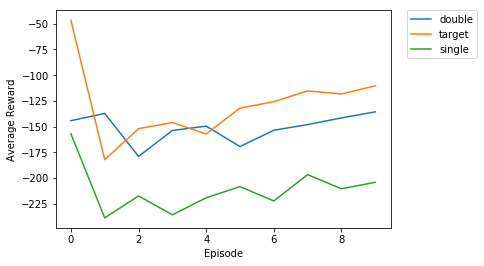

In [8]:
agent_t = Agent_q_soft_target(env.observation_space.shape[0], env.action_space.n)
rewards_target = test_run(env, agent_t, update=True)
agent_t.save_model(10);

print("\n____________________")

agent_d = Agent_q(env.observation_space.shape[0], env.action_space.n)
rewards_double = test_run(env, agent_d)
agent_d.save_model(10);

print("\n____________________")

agent_s = Agent_q_double(env.observation_space.shape[0], env.action_space.n)
rewards_single = test_run(env, agent_s)
agent_s.save_model(10);

plt.plot(rewards_double, label = "double")
plt.plot(rewards_target, label = "target")
plt.plot(rewards_single, label = "single")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlabel('Episode')
plt.ylabel('Average Reward')

In [10]:
agent_t = Agent_q_soft_target(env.observation_space.shape[0], env.action_space.n)
agent_t.load_model(10)
playtest(env,agent_t)